In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from sklearn.utils.extmath import randomized_svd as rsvd
rsvd.__name__ = "rsvd"

In [2]:
def svd_rank_experiment(X, func, ranks, *args, **kwargs):
    # No randosizeess, so no need for recomputation
    to = []
    eo = []
    
    t0 = time.perf_counter()
    U, s, Vh = func(X)
    t1 = time.perf_counter()
    
    for k in tqdm.tqdm(ranks):
        X_ = U[:, :k] * s[:k] @ Vh[:k]
        er = np.linalg.norm(X - X_)
        to.append(t1 - t0)
        eo.append(er)

    to = np.array(to).reshape(-1, 1)
    eo = np.array(eo).reshape(-1, 1)
    
    return to, eo

def rsvd_rank_experiment(X, func, ranks, n_trials: int = 5):
    to = []
    eo = []
    
    for k in tqdm.tqdm(ranks):
        ti = []
        ei = []
        
        for trial in range(n_trials):
            t0 = time.perf_counter()
            U, s, Vh = func(X, k)
            t1 = time.perf_counter()
            
            X_ = U[:, :k] * s[:k] @ Vh[:k]
            er = np.linalg.norm(X - X_)

            ti.append(t1 - t0)
            ei.append(er)
        
        to.append(ti)
        eo.append(ei)

    to = np.array(to)
    eo = np.array(eo)
    
    return to, eo

def rank_metrics(ranks, times, errors, svd_times):
    metrics = {}
    metrics["rank"] = ranks
    metrics["time_avg"] = times.mean(axis=1)
    metrics["time_std"] = times.var(axis=1)
    metrics["error_avg"] = errors.mean(axis=1)
    metrics["error_std"] = errors.var(axis=1)
    metrics["speedup_avg"] = svd_times.mean(axis=1) / metrics["time_avg"]
    metrics["speedup_std"] = 0 * metrics["speedup_avg"]
    return metrics

In [3]:
def random_matrix(m, n, singular_values):
    k = min(m, n)
    s = singular_values
    U = ortho_group.rvs(m)
    Vh = ortho_group.rvs(n)
    return U[:, :k] * s[:k] @ Vh[:k]

## Experiment 1: Low-rank approximation of a matrix

In [4]:
def experiment_1(m: int, n:int, s: np.array, ranks: list, n_trials: int, hparams: list):    
    # Run experiment over many ranks
    
    X = random_matrix(m, n, s)
    print("Matrix:", X.shape, "ranks:", ranks, "n_trials:", n_trials)
    
    results = []
    
    # Exact 
    f = np.linalg.svd
    func = lambda x: f(x, full_matrices=False)
    svd_times, errors = svd_rank_experiment(X, func, ranks, n_trials)
    
    metrics = {}
    metrics["name"] = [f.__name__] * len(ranks)
    metrics = {**metrics, **rank_metrics(ranks, svd_times, errors, svd_times)}
    results.append(metrics)
    
    # Approximate    
    for hparam in hparams:
        f = rsvd
        func = lambda x, k: f(x, k, **hparam)
        times, errors = rsvd_rank_experiment(X, func, ranks, n_trials) 
        label = ",".join([f"{k}={v}" for k, v in hparam.items()])
        
        metrics = {}
        metrics["name"] = [f.__name__ + f" ({label})"] * len(ranks)
        metrics = {**metrics, **rank_metrics(ranks, times, errors, svd_times)}
        results.append(metrics)
    
    return results

def plot_1(results: list, measures: list, dist: str, size: list):
    m, n = size
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    for i, measure in enumerate(measures, 1):
        for j, metrics in enumerate(results):
            ax[i].errorbar(
                ranks, 
                metrics[f"{measure}_avg"], 
                metrics[f"{measure}_std"], 
                label=metrics["name"][0], 
                alpha=1/(j+1)
            )
            ax[i].scatter(ranks, metrics[f"{measure}_avg"])
            # ax[i].bar(
            #     ranks, 
            #     metrics[f"{measure}_avg"],  
            #     label=metrics["name"][0], 
            # )
    
        ax[i].set_title(f"$k_{{rank}}$ approximation of $X \\sim {dist} \\in R^{{{m}x{n}}}$")
        ax[i].set_xlabel("k")
        ax[i].set_ylabel(measure)
        ax[i].legend()
    
    # Plot of 1 - cumsum(singular values)
    ax[0].plot(1 - np.cumsum(s) / s.sum())
    ax[0].set_title(f"Singular values of $X \\sim {dist} \\in R^{{{m}x{n}}}$")
    ax[0].set_xlabel("singular values")
    ax[0].set_ylabel("1 - cumulative sum of singular values")
    
    plt.show()

### 1.1: Square Matrix $\to m=n$

In [5]:
m = n = 1000
r = min(m, n)
num = 10
ranks = np.linspace(int(r / num), r, num=num, dtype=int)
n_trials = 1 # TODO: Possibly can remove since variance is insignificant
rsvd_hparams = [
    {"n_oversamples": 0, "n_iter": 0},
    {"n_oversamples": 25, "n_iter": 0},
    {"n_oversamples": 0, "n_iter": 1},
] # control speed-accuracy tradeoff

size  = []
size.append((m, n))

In [6]:
%%time

results = {}

np.random.seed(42)
s = np.ones(n)
results["I"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

np.random.seed(42)    
s = np.sort(np.random.standard_exponential(n))[::-1]
results["Exp"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

np.random.seed(42)    
s = np.sort(np.abs(np.random.standard_cauchy(n)))[::-1]
results["C"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

square_results = results

Matrix: (1000, 1000) ranks: [ 100  200  300  400  500  600  700  800  900 1000] n_trials: 1


100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Matrix: (1000, 1000) ranks: [ 100  200  300  400  500  600  700  800  900 1000] n_trials: 1


100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Matrix: (1000, 1000) ranks: [ 100  200  300  400  500  600  700  800  900 1000] n_trials: 1


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]

CPU times: user 15.3 s, sys: 2.86 s, total: 18.1 s
Wall time: 12.7 s


### 1.2: Tall Matrix $\to m>n$

In [7]:
m, n = 5000, 100
r = min(m, n)
num = 10
ranks = np.linspace(int(r / num), r, num=num, dtype=int)
n_trials = 1 # TODO: Possibly can remove since variance is insignificant
rsvd_hparams = [
    {"n_oversamples": 0, "n_iter": 0},
    {"n_oversamples": 25, "n_iter": 0},
    {"n_oversamples": 0, "n_iter": 1},
] # control speed-accuracy tradeoff

size.append((m, n))

In [8]:
results = {}

np.random.seed(42)
s = np.ones(n)
results["I"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

np.random.seed(42)    
s = np.sort(np.random.standard_exponential(n))[::-1]
results["Exp"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

np.random.seed(42)    
s = np.sort(np.abs(np.random.standard_cauchy(n)))[::-1]
results["C"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

tall_results = results

Matrix: (5000, 100) ranks: [ 10  20  30  40  50  60  70  80  90 100] n_trials: 1


100%|██████████| 10/10 [00:00<00:00, 77.81it/s]


Matrix: (5000, 100) ranks: [ 10  20  30  40  50  60  70  80  90 100] n_trials: 1


100%|██████████| 10/10 [00:00<00:00, 75.39it/s]


Matrix: (5000, 100) ranks: [ 10  20  30  40  50  60  70  80  90 100] n_trials: 1


100%|██████████| 10/10 [00:00<00:00, 61.52it/s]


### 1.3: Fat Matrix $\to m<n$

In [9]:
m, n = 100, 5000
r = min(m, n)
num = 10
ranks = np.linspace(int(r / num), r, num=num, dtype=int)
n_trials = 1 # TODO: Possibly can remove since variance is insignificant
rsvd_hparams = [
    {"n_oversamples": 0, "n_iter": 0},
    {"n_oversamples": 25, "n_iter": 0},
    {"n_oversamples": 0, "n_iter": 1},
] # control speed-accuracy tradeoff

size.append((m, n))

In [10]:
results = {}

np.random.seed(42)
s = np.ones(n)
results["I"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

np.random.seed(42)    
s = np.sort(np.random.standard_exponential(n))[::-1]
results["Exp"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

np.random.seed(42)    
s = np.sort(np.abs(np.random.standard_cauchy(n)))[::-1]
results["C"] = experiment_1(m, n, s, ranks, n_trials, rsvd_hparams)

fat_results = results

Matrix: (100, 5000) ranks: [ 10  20  30  40  50  60  70  80  90 100] n_trials: 1


100%|██████████| 10/10 [00:00<00:00, 84.93it/s]


Matrix: (100, 5000) ranks: [ 10  20  30  40  50  60  70  80  90 100] n_trials: 1


100%|██████████| 10/10 [00:00<00:00, 81.13it/s]


Matrix: (100, 5000) ranks: [ 10  20  30  40  50  60  70  80  90 100] n_trials: 1


100%|██████████| 10/10 [00:00<00:00, 84.69it/s]


### 1.4: Plot results

# $m=n$

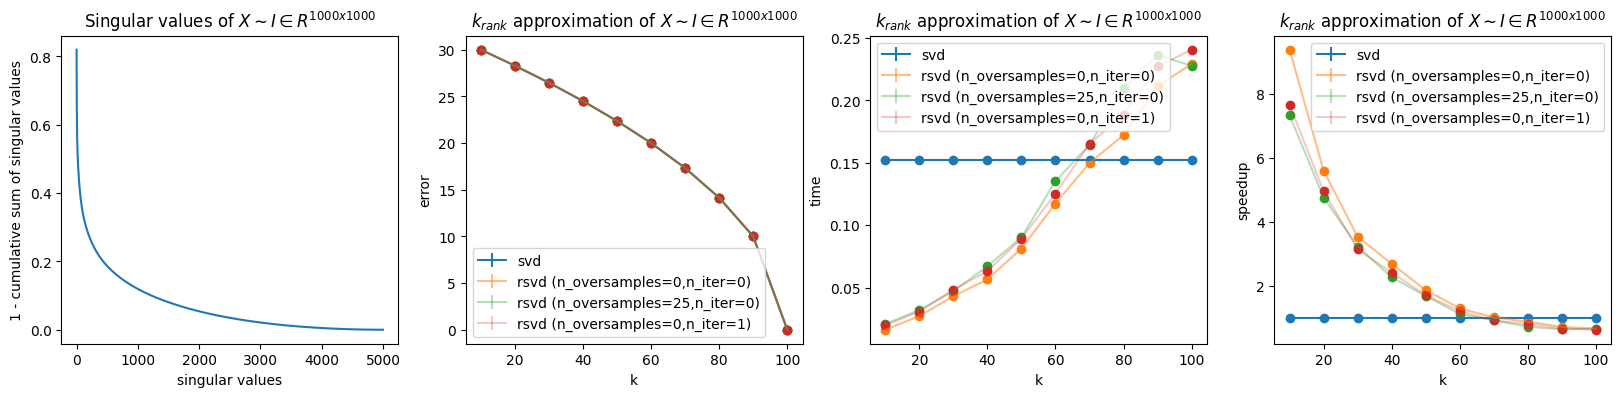

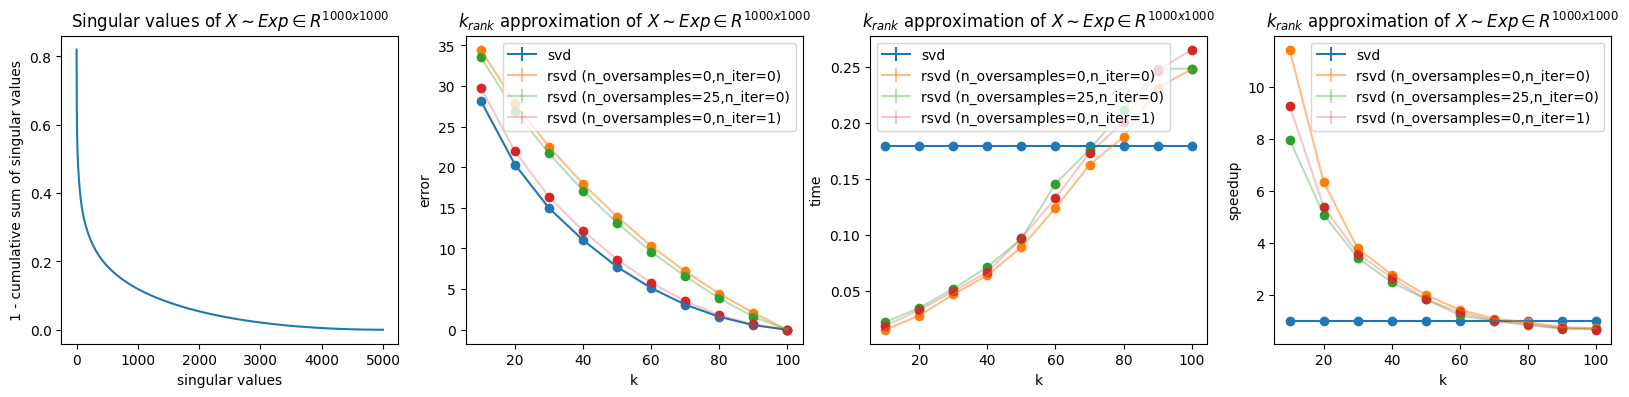

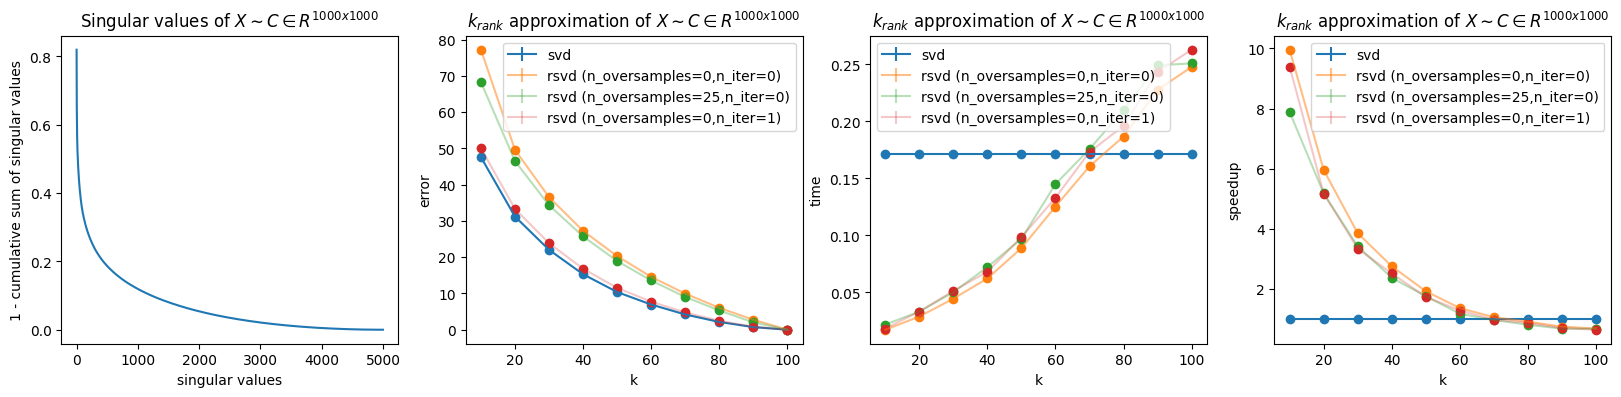

---

# $m>n$

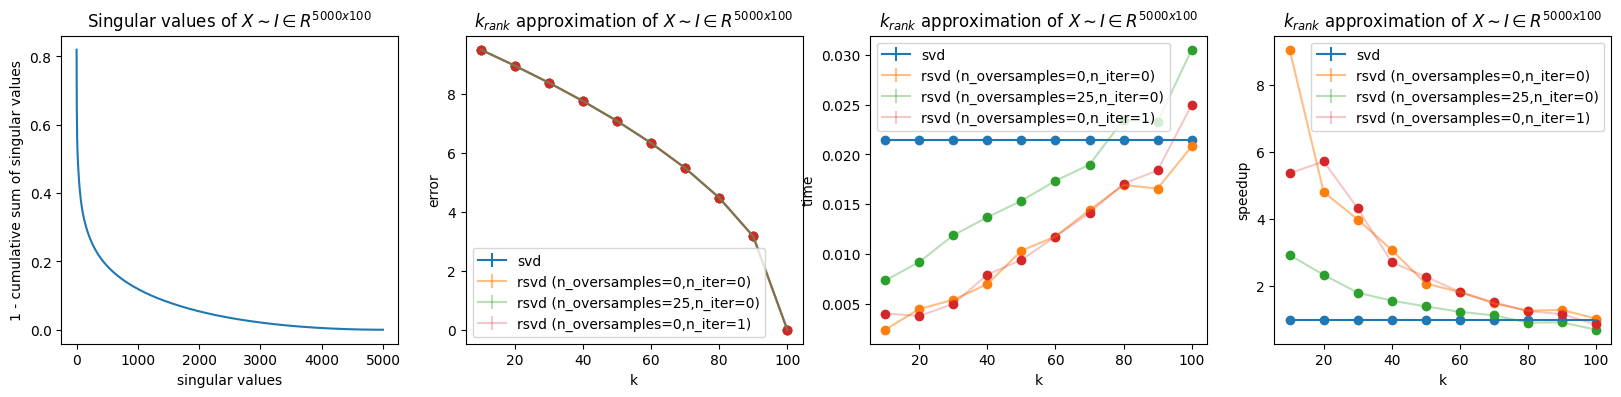

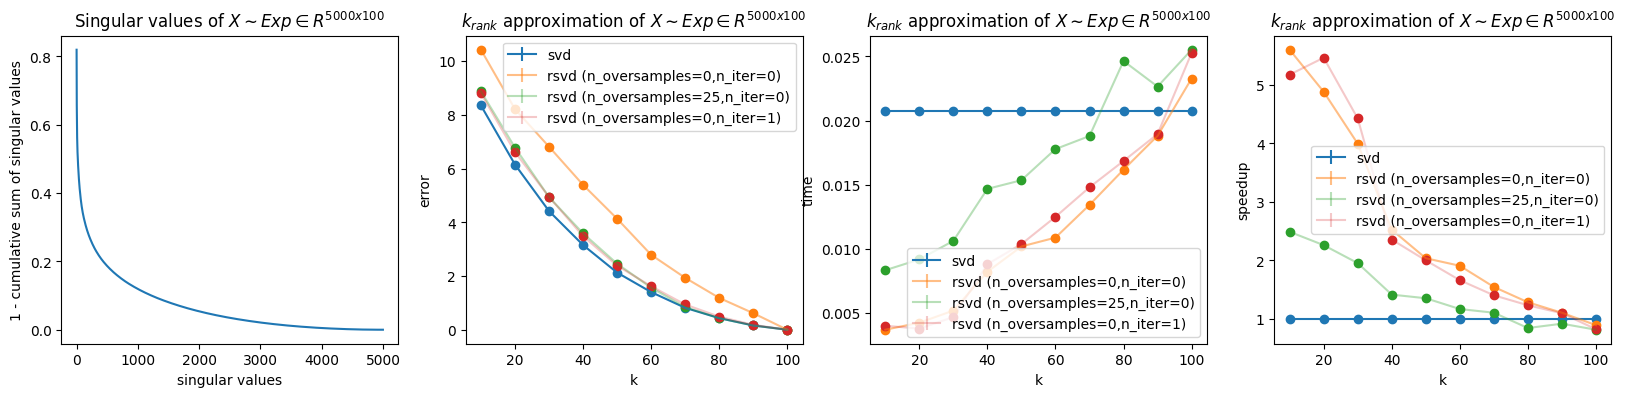

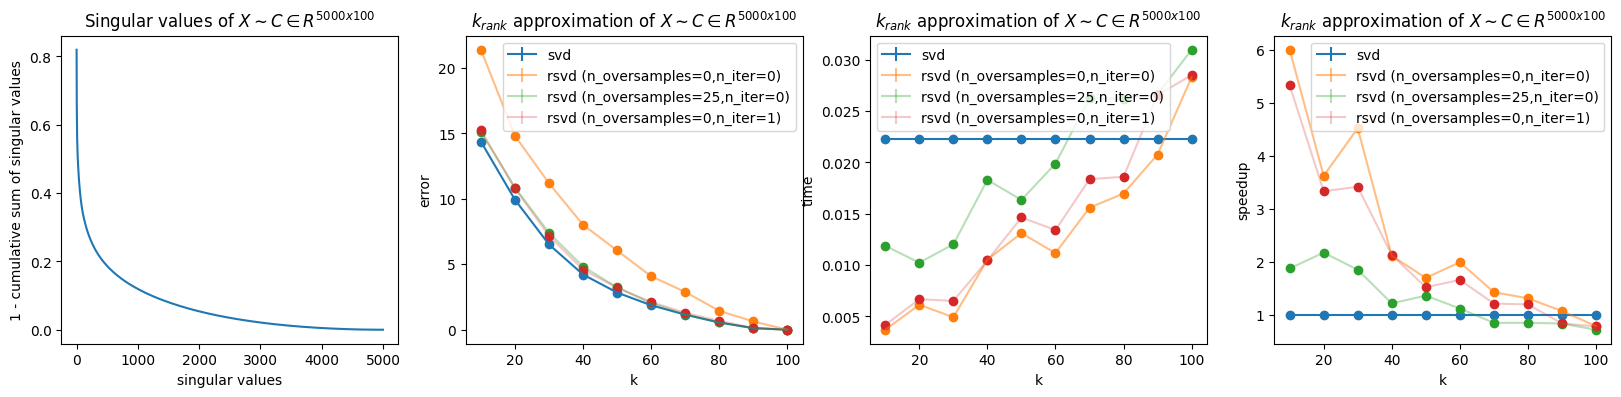

---

# $m<n$

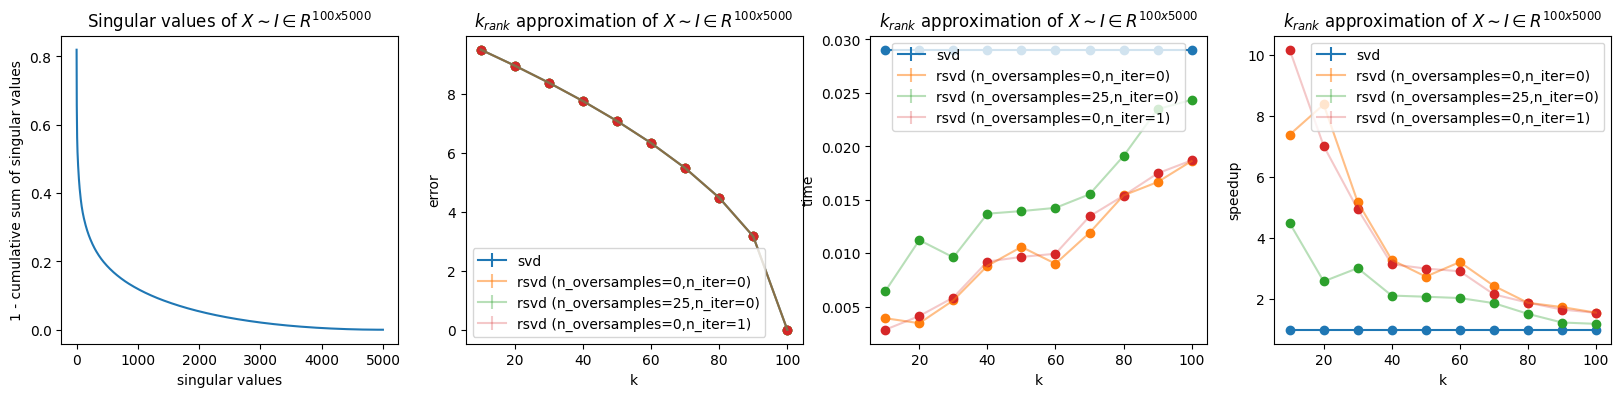

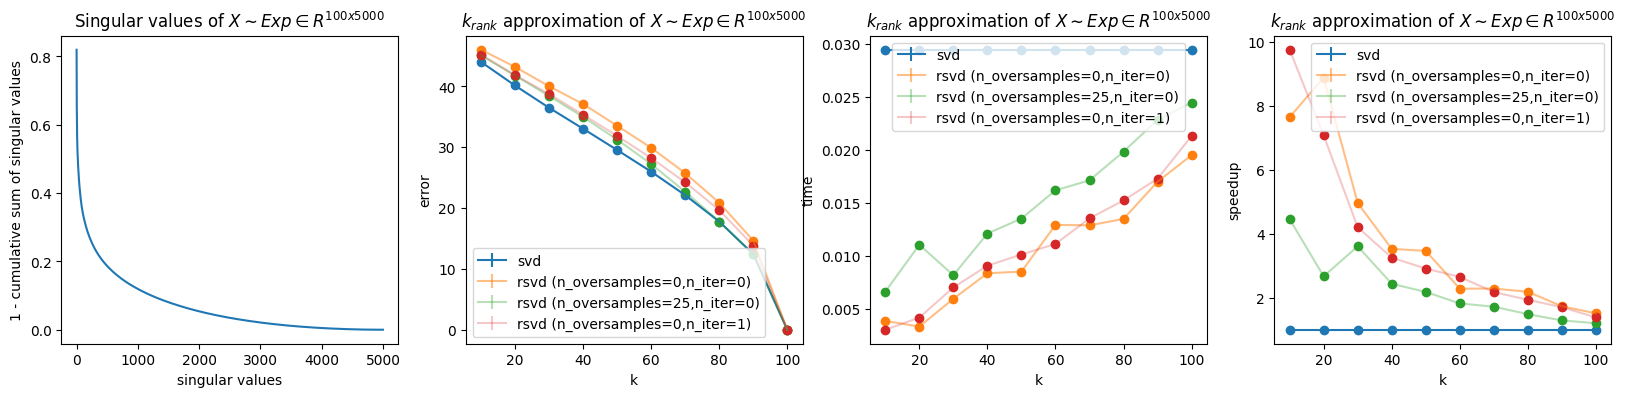

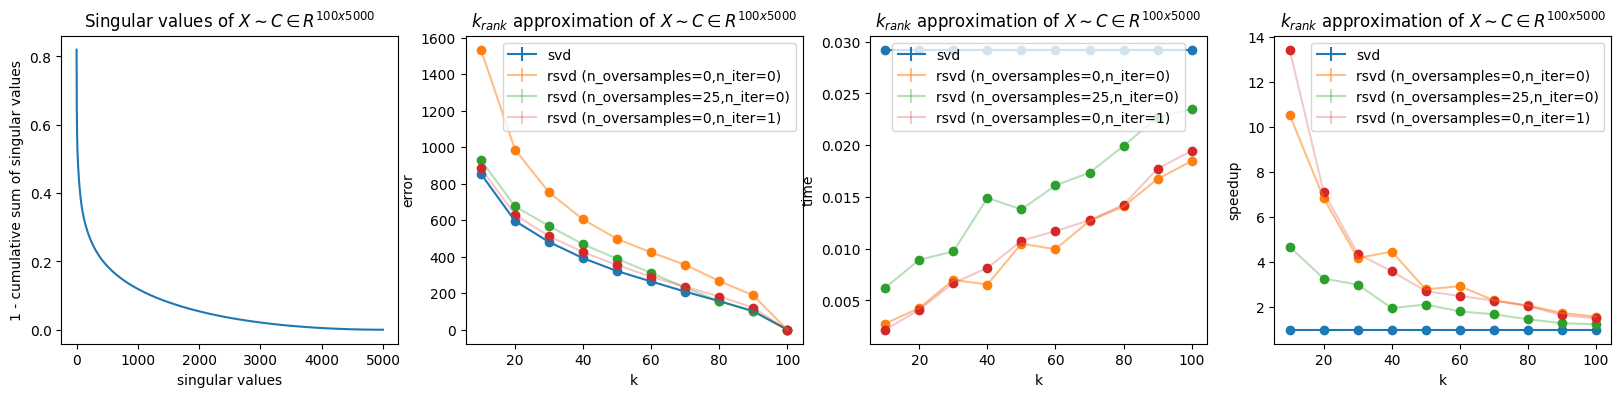

---

In [11]:
from IPython.display import Markdown

all_results = [square_results, tall_results, fat_results]
measures = ["error", "time", "speedup"]
problems = ["# $m=n$", "# $m>n$", "# $m<n$"]

for i, results in enumerate(all_results):
    display(Markdown(problems[i]))
    for name, result in results.items():
        plot_1(result, measures, name, size[i])
    display(Markdown("---"))

## Experiment 2: rSVD Hyperparameters

In [12]:
# Experiments demonstrating impact of parameters on runtime and accuracy (which depend on properties of data)
# Requires reviewing https://arxiv.org/abs/0909.4061
# above is theoretical justification
# and https://github.com/scikit-learn/scikit-learn/blob/6bf2061f7/sklearn/utils/extmath.py#L524C3-L530C6
# above is basically the meat of the implementation

# NOTE: Method is best when high-dimensional data exhibits primarily low-dimensional structure (has been empirically shown for real-world datasets)

# Some applications only care about svd to reduce matmul ops. 
# Can we use rank approx rsvd to save in both decomposition time and matmul ops without too much loss in quality?

# Relevant implementations
# https://scikit-learn.org/dev/modules/generated/sklearn.utils.extmath.randomized_svd.html
# https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.TruncatedSVD.html

## Experiment 3: Real world dataset/application

In [13]:
# Only if time permits